In [21]:
import pandas as pd
import numpy as np
import os, os.path

In [22]:
features = ["Tm", "Rec_ID", "AvgTamb", "AvgHamb", "AvgGSi00", "AvgTSi00", 
            "AvgSPN1_G", "AvgSPN1_D", "AvgWind_S", "AvgWind_D", "AvgAir_P"]
dataf = pd.DataFrame([], columns = features)

In [23]:
def is_non_zero_file(fpath):  
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0

In [24]:
# get all txt files from the directory init_dir and all sub-directories
init_dir = "401"
flist  = []
 
for root, dirs, files in os.walk(init_dir):
    try:
        for f in files:
            fullpath = os.path.join(root, f)
            if (is_non_zero_file(fullpath)) & (os.path.splitext(fullpath)[1] == '.txt'):
                flist.append(fullpath)
    except Exception as e:
        raise e
        print( "No files found here!")
# print(flist[1])
print(len(flist))



1122


In [26]:
avg_len = 10 # average for every 10 minutes
seq_len = 18 #  3 hours * 6 (four is the number of 15 min intervals in 1 hour) 

channels = 32 # LSTM parameters/neurons


In [27]:
# generate all the 15-min averages for all the files and all the telemetries available
features_to_analyze = features[2:]
print(features_to_analyze)
featurs_len = len(features_to_analyze)
print(featurs_len) 

['AvgTamb', 'AvgHamb', 'AvgGSi00', 'AvgTSi00', 'AvgSPN1_G', 'AvgSPN1_D', 'AvgWind_S', 'AvgWind_D', 'AvgAir_P']
9


In [28]:
dataAvg = []

# it's one day analysis 

for fullpath in flist:
    # arrays for the 15 min means
    data = pd.read_csv(fullpath,delimiter="\t")        
    pd_len = data.shape[0]  # all length of the sequence
    #     print(fullpath)
    # and then average everything using 15 min reading
    for i in range(0,pd_len-avg_len,avg_len):
        seq_in = data.iloc[i:i + avg_len][features_to_analyze].mean()  # not inclusive the higher limit
        seq_in = np.array(seq_in).reshape(featurs_len)
        dataAvg.append(seq_in)
    # and now for list of avg values make a test data    
print("Total sequences: {}".format(len(dataAvg)))

Total sequences: 160414


In [29]:
dataAvg[0]

array([  2.88369000e+01,   7.82704000e+01,  -4.34000000e-02,
         2.69092000e+01,   4.28880000e+00,   3.10970000e+00,
         1.92600000e-01,   1.45167900e+02,   1.00240440e+03])

In [30]:
dataX = []
dataY = []

# the predictor is AvgSPN1_D, it has index #5 in the array

for element in range(0, len(dataAvg)-seq_len-1, 1):
    # and now make a list of test data from avg values
    Z = np.array(dataAvg[element:element+seq_len]).reshape(seq_len,featurs_len)
    dataX.append(Z)
    Z1 = np.array(dataAvg[(element+1):(element+seq_len+1)]).reshape(seq_len,featurs_len)
    dataY.append(Z1[:,5]) # Output param has index 5  
    
print("Total sequences: {}".format(len(dataX)))

Total sequences: 160395


In [31]:
print("Total sequences: {}".format(len(dataY)))
len(dataY[1])

Total sequences: 160395


18

In [32]:
n_patterns = len(dataX)
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_len, featurs_len))
print(X.shape)

(160395, 18, 9)


Normalize all the sequence, 

In [33]:
Mx = X.max(axis=1).max(axis=0)
Mn = X.min(axis=1).min(axis=0)
M = X.mean(axis=1).mean(axis=0)
MM = Mx-Mn

In [34]:
Mx, Mn, M, MM

(array([   37.3774,   100.8646,  1246.2757,    71.8775,  1288.753 ,
          685.1596,     5.0233,   297.428 ,  1009.1737]),
 array([  2.18326000e+01,   3.77004000e+01,  -5.55200000e-01,
          2.01636000e+01,   2.28670000e+00,   1.33910000e+00,
         -4.97000000e-02,   6.60790000e+01,   9.95899100e+02]),
 array([  2.84886336e+01,   7.85908104e+01,   1.78506453e+02,
          3.18733944e+01,   1.89840086e+02,   1.07767520e+02,
          6.59120697e-01,   1.71581223e+02,   1.00275718e+03]),
 array([   15.5448,    63.1642,  1246.8309,    51.7139,  1286.4663,
          683.8205,     5.073 ,   231.349 ,    13.2746]))

In [35]:
X.shape

(160395, 18, 9)

In [36]:
for i in (range(X.shape[0])):
    for j in (range(X.shape[1])):
        X[i][j] -= M
        X[i][j] /= MM

In [37]:
Y = np.reshape(dataY, (n_patterns, seq_len, 1))
print(Y.shape)

(160395, 18, 1)


In [38]:
Y -= M[5]         
Y /= MM[5]    

In [39]:
np.savez_compressed('data9', dataX=dataX, dataY=dataY, X=X, Y=Y)
# X,Y normalized and reshaped

In [40]:
DataSet = np.load('data9.npz')

In [41]:
X = DataSet['X']
Y = DataSet['Y']
n_patterns = len(X)
print(n_patterns)
print(X.shape, Y.shape)

160395
(160395, 18, 9) (160395, 18, 1)


In [42]:
samples = X.shape[0]
timesteps = X.shape[1]
model_features = X.shape[2]


In [48]:
import numpy as np
import sys

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input
from keras.optimizers import RMSprop, Adam

from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Activation, Dense

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf

In [44]:
print(Y.shape)
# y = np.reshape(Y, (n_patterns, seq_len, 1))
y = Y
print(y.shape)

(160395, 18, 1)
(160395, 18, 1)


In [49]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-gentext-Telemetry2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [61]:
# define LSTM configuration
n_neurons = channels
n_batch = 32
n_epoch = 15
# create LSTM
model = Sequential()
model.add(LSTM(channels, dropout_W=0.0, dropout_U=0.3, input_shape=(timesteps, model_features), return_sequences=True))

# model.add(LSTM(channels, dropout_W=0.2, dropout_U=0.2, input_shape=(timesteps, channels, model_features), return_sequences=True))

model.add(TimeDistributed(Dense(72)))
model.add(Activation('relu'))
model.add(Dense(1))
# model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
# mean_absolute_percentage_error
print(model.summary())
# train LSTM
history = model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=1, 
          callbacks=callbacks_list, validation_split=0.05)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)


C:\Users\Igor\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, recurrent_dropout=0.3, return_sequences=True, input_shape=(18, 9), dropout=0.0)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 18, 128)           70656     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 72)            9288      
_________________________________________________________________
activation_2 (Activation)    (None, 18, 72)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 18, 1)             73        
Total params: 80,017
Trainable params: 80,017
Non-trainable params: 0
_________________________________________________________________
None
Train on 152375 samples, validate on 8020 samples
Epoch 1/15
152375/152375 [==============================] - 86s - loss: 0.0018 - val_loss: 0.0012
Epoch 2/15
152375/152375 [==============================] - 86s - loss: 0.0016 - val_loss: 0.0012
Epoch 3/15
152375/1

In [64]:
print(channels, avg_len, seq_len)

128 10 18


In [65]:
print(result.shape)
print(len(result[0,:,0]))
# for value in result[0,:,0]:
#      print('%.1f' % value)

(160395, 18, 1)
18


In [66]:
print(y.shape)
Y_original = y[:,y.shape[1]-1,0] 
Y_predicted = result[:,result.shape[1]-1,0]
Res = Y_original - Y_predicted

(160395, 18, 1)


In [67]:
print(Res.shape)
print(Y_original.shape)
# print(R[0])

(160395,)
(160395,)


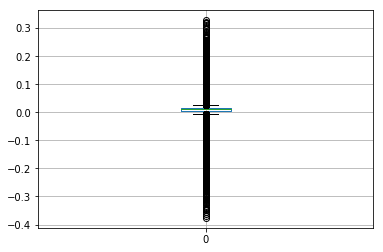

In [68]:
import matplotlib.pyplot as plt
from pandas import DataFrame
results = DataFrame(Res)
results.boxplot()
plt.show()

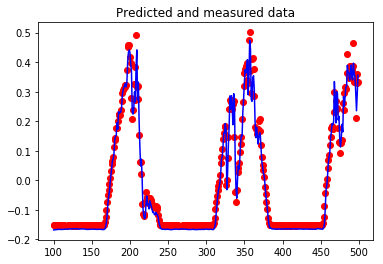

In [69]:
import matplotlib.pyplot as plt
frm = 100
to = 500
intervals15min = range(frm, to)
plt.title('Predicted and measured data')
plt.legend()
plt.plot(intervals15min, Y_original[intervals15min], 'ro', label='Y_original')
plt.plot(intervals15min, Y_predicted[intervals15min], 'b', label='Y_predicted')
plt.show()

In [60]:
frm = 100
to = 150
intervals15min = range(frm, to)
print( Y_predicted[intervals15min])
print( Y_original[intervals15min])


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.15314387 -0.1530418  -0.15284599 -0.15297629 -0.15323512 -0.15303931
 -0.15280928 -0.15279173 -0.15289337 -0.15280095 -0.15293183 -0.15300144
 -0.15273558 -0.15267182 -0.15316727 -0.15330912 -0.15325867 -0.15345843
 -0.15337303 -0.15296634 -0.15289688 -0.15311068 -0.15312998 -0.15306827
 -0.15331599 -0.15345024 -0.15359604 -0.15307017 -0.15293329 -0.15265559
 -0.15327607 -0.15313919 -0.15298608 -0.15292788 -0.15279978 -0.15291413
 -0.15291969 -0.15260133 -0.15240318 -0.15248595 -0.15260616 -0.15271554
 -0.15270984 -0.15298155 -0.15301606 -0.15298798 -0.15303741 -0.15301752
 -0.15287699 -0.15297512]


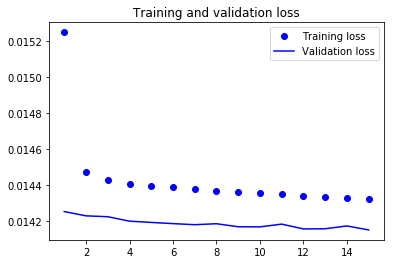

In [58]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()